# Пробуем сделать LSTM модель по транзакциям для предсказания следующей транзакции

In [1]:
import gc
import random
import pickle
import glob
from datetime import datetime

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from transaction_dataset import (
    TransactionsDataset,
    dataloader_collate
)
from models_lstm import TransactionLSTM
from trainers import TransactionTrainer
from metrics_losses import (
    BCELogitsLoss,
    normalized_average_precision
)
from utils import (
    _fix_seeds,
    filter_user_item_pairs,
    get_user_item_matrix,
    blend_product_lists,
    plot_loss_metrics
)
from settings import(
    baseline_items,
    baseline_popular,
    check_clients
)

import matplotlib.pyplot as plt
#plt.style.use('seaborn-poster')

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
gc.enable()

device = torch.device("cuda:0")

if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
else:
    from torch import FloatTensor, LongTensor

%matplotlib inline

## Собираем датасет

In [2]:
_fix_seeds(42)
valid_time = datetime.strptime('2019-03-01 00:00:00', '%Y-%m-%d %H:%M:%S')
valid_chunks = [
    '../_processed_data/client_tr_history_4.tsv', 
    '../_processed_data/client_tr_history_0.tsv',
    '../_processed_data/client_tr_history_15.tsv', 
    '../_processed_data/client_tr_history_16.tsv', 
    '../_processed_data/client_tr_history_6.tsv'
]
train_chunks = sorted(glob.glob('../_processed_data/client_tr_history_*'))
train_chunks = [chunk for chunk in train_chunks
                if chunk not in valid_chunks and chunk != '../_processed_data/client_tr_history_20.tsv']

# get old product_index
with open('../_model_files/incremental_encoder_dict_01_23_01.pckl', 'rb') as f:
    inc_encoder = pickle.load(f)
prodcut_index = inc_encoder['product_id']
    
train_dataset = TransactionsDataset(train_chunks, valid_time, prodcut_index, check_clients)
valid_dataset = TransactionsDataset(valid_chunks, valid_time, prodcut_index, check_clients)

# temp datasets for code check
#train_dataset = TransactionsDataset([train_chunks[0]], valid_time, prodcut_index, check_clients)
#valid_dataset = TransactionsDataset([valid_chunks[0]], valid_time, prodcut_index, check_clients)

print(len(train_dataset))
print(len(valid_dataset))

309it [00:00, 1492.55it/s]

../_processed_data/client_tr_history_1.tsv


20000it [00:12, 1607.08it/s]
321it [00:00, 1620.43it/s]

../_processed_data/client_tr_history_10.tsv


20000it [00:12, 1578.03it/s]
307it [00:00, 1525.07it/s]

../_processed_data/client_tr_history_11.tsv


20000it [00:12, 1591.07it/s]
307it [00:00, 1561.44it/s]

../_processed_data/client_tr_history_12.tsv


20000it [00:12, 1623.91it/s]
167it [00:00, 1660.94it/s]

../_processed_data/client_tr_history_13.tsv


20000it [00:12, 1565.87it/s]
336it [00:00, 1617.41it/s]

../_processed_data/client_tr_history_14.tsv


20000it [00:12, 1618.34it/s]
174it [00:00, 1727.67it/s]

../_processed_data/client_tr_history_17.tsv


20000it [00:12, 1661.82it/s]
345it [00:00, 1749.86it/s]

../_processed_data/client_tr_history_18.tsv


20000it [00:12, 1606.13it/s]
331it [00:00, 1678.06it/s]

../_processed_data/client_tr_history_19.tsv


20000it [00:12, 1662.31it/s]
325it [00:00, 1541.45it/s]

../_processed_data/client_tr_history_2.tsv


20000it [00:12, 1582.26it/s]
504it [00:00, 1625.04it/s]

../_processed_data/client_tr_history_3.tsv


20000it [00:11, 1669.93it/s]
301it [00:00, 1541.80it/s]

../_processed_data/client_tr_history_5.tsv


20000it [00:12, 1572.82it/s]
174it [00:00, 1735.36it/s]

../_processed_data/client_tr_history_7.tsv


20000it [00:12, 1655.45it/s]
330it [00:00, 1656.60it/s]

../_processed_data/client_tr_history_8.tsv


20000it [00:11, 1681.22it/s]
543it [00:00, 1809.66it/s]

../_processed_data/client_tr_history_9.tsv


20000it [00:12, 1558.20it/s]
323it [00:00, 1662.26it/s]

../_processed_data/client_tr_history_4.tsv


20000it [00:12, 1657.38it/s]
255it [00:00, 2547.37it/s]

../_processed_data/client_tr_history_0.tsv


20000it [00:11, 1694.78it/s]
323it [00:00, 1637.11it/s]

../_processed_data/client_tr_history_15.tsv


20000it [00:13, 1476.83it/s]
172it [00:00, 1716.89it/s]

../_processed_data/client_tr_history_16.tsv


20000it [00:12, 1639.55it/s]
323it [00:00, 1604.19it/s]

../_processed_data/client_tr_history_6.tsv


20000it [00:12, 1654.18it/s]

268982
89643


In [3]:
loader_params = {
    'batch_size':80,
    'shuffle':True,
    'pin_memory':False,
    'num_workers':4,
}

train_loader = DataLoader(train_dataset, 
                          collate_fn=dataloader_collate, 
                          **loader_params)
valid_loader = DataLoader(valid_dataset, 
                          collate_fn=dataloader_collate, 
                          **loader_params)

## Обучаем LSTM

In [4]:
model = TransactionLSTM(train_dataset.num_products, embedding_size=128, lstm_size=512, lstm_layers=1)
loss = BCELogitsLoss()

optimizer_params = {'lr': 1e-3, 'weight_decay': 1e-6}
scheduler_params = {'T_max': 5, 'eta_min': 1e-5, 'last_epoch': -1}

optimizer = optim.Adam(model.parameters(), **optimizer_params)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, **scheduler_params)
#scheduler = None

path_to_save_model = '../_model_files/model_lstm_02_20.pth'
trainer = TransactionTrainer(path_to_save_model, train_loader, valid_loader, loss, 10, device)

In [5]:
%%time
trainer.run_model(model, optimizer, scheduler)

Starting epoch: 0 | time: 08:40:32
LR: [0.001]
valid: 100%|██████████| 1121/1121 [09:52<00:00,  1.89it/s, nmap_batch - 0.07602, bce_logits_loss - 0.001867]
Valid avg loss: 0.001735
Valid avg nmap: 0.062484
*** Model saved! ***

Starting epoch: 1 | time: 09:23:57
LR: [0.000657963412215599]
valid: 100%|██████████| 1121/1121 [09:53<00:00,  1.89it/s, nmap_batch - 0.07776, bce_logits_loss - 0.001861]
Valid avg loss: 0.001692
Valid avg nmap: 0.064379
*** Model saved! ***

Starting epoch: 2 | time: 10:07:13
LR: [0.00010453658778440107]
valid: 100%|██████████| 1121/1121 [09:53<00:00,  1.89it/s, nmap_batch - 0.07866, bce_logits_loss - 0.001826]
Valid avg loss: 0.001654
Valid avg nmap: 0.0657
*** Model saved! ***

Starting epoch: 3 | time: 10:50:30
LR: [0.00010453658778440096]
valid: 100%|██████████| 1121/1121 [09:54<00:00,  1.89it/s, nmap_batch - 0.07866, bce_logits_loss - 0.001829]
Valid avg loss: 0.001649
Valid avg nmap: 0.0657
*** Model saved! ***

Starting epoch: 4 | time: 11:33:49
LR: [0.0

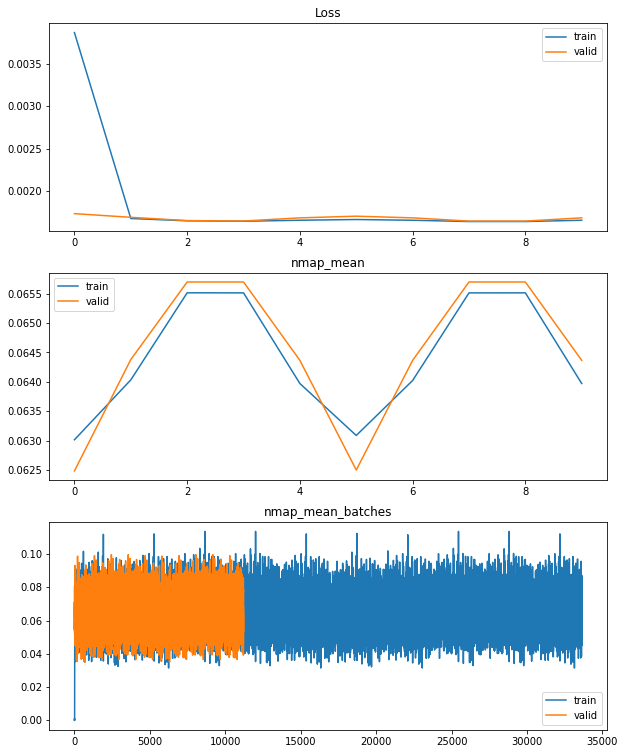

In [6]:
# lstm_size=512, 10 epochs
plot_loss_metrics(trainer.loss_history, {'nmap_mean': trainer.nmap_history, 
                                         'nmap_mean_batches': trainer.nmap_history_batches})